In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import datetime

import gymnasium as gym
import torch

from policy_based import PolicyNetFunc, PolicyNetTrainer, PolicyNetTester, PolicyNetTrainerWithBase, ValueNetFunc
from deep_q import Discrete1ContinuousAction
from env import Env, get_action_discreter
from utils import clear_target_path, show_gif_on_jupyternb, to_gif
from train_test_util import start_test, start_train, StandarTestProcess, StandarTrainProcess

### 使用CarPole-V1 环境，测试Policy-Based REINFORCE 算法

In [ ]:
GYM_ENV_NAME = 'CartPole-v1'
env = Env.from_env_name(GYM_ENV_NAME)
RESULT_DIR_NAME='cartpoleV1'

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/REINFORCE')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/REINFORCE.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/REINFORCE')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()


TRAIN_EPOCH = 1000
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   env.get_action_dim()[0], 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainer(policy_func=policy_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH)

#### 训练模型

In [ ]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

#### 开始测试

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用CarPole-V1 环境，测试Policy-Based + 基线的 REINFORCE 算法

In [ ]:
GYM_ENV_NAME = 'CartPole-v1'
env = Env.from_env_name(GYM_ENV_NAME)
RESULT_DIR_NAME='cartpoleV1'

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/REINFORCE_With_BASE')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/REINFORCE_With_BASE.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/REINFORCE_With_BASE')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()


TRAIN_EPOCH = 1000
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

value_func = ValueNetFunc(
                env.get_state_dim()[0], 
                hidden_dim=HIDDEN_DIM, 
                device=torch.device('cuda') if _USE_CUDA else None)

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   env.get_action_dim()[0], 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainerWithBase(
                                  policy_func=policy_func,
                                  value_func=value_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH)

#### 训练模型

In [ ]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

#### 测试模型

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用Pendulum-v1 环境，测试Policy-Based REINFORCE 算法

In [ ]:
GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'

env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/policy_based')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/policy_model.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}_policy')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 1000
HIDDEN_DIM = 512
LEARNING_RATE = 1e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   action_nums=BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainer(policy_func=policy_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH,
                                  action_converter=get_action_discreter(env, BINS))

#### 训练模型

In [ ]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

#### 开始测试

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env,
    action_converter=get_action_discreter(env, BINS)
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用Pendulum-v1 环境，测试Policy-Based + 基线的 REINFORCE 算法

In [5]:
GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'

env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/REINFORCE_With_BASE')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/REINFORCE_With_BASE.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/REINFORCE_With_BASE')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 3000
HIDDEN_DIM = 256
LEARNING_RATE = 2e-8
VALUE_LEARNING_RATE = 5e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

value_func = ValueNetFunc(
                env.get_state_dim()[0], 
                hidden_dim=HIDDEN_DIM, 
                device=torch.device('cuda') if _USE_CUDA else None)

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   action_nums=BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainerWithBase(
                                  policy_func=policy_func,
                                  value_func=value_func,
                                  value_learning_rate=VALUE_LEARNING_RATE,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH,
                                  action_converter=get_action_discreter(env, BINS))

INFO     | env: - action: Box(-2.0, 2.0, (1,), float32), space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32); 2024-06-26 02:34:57 print_state_action_dims:68


#### 训练模型

In [6]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

INFO     | train_test_util: - start training, now datetime: 2024-06-26 02:34:58.975767; 2024-06-26 02:34:58 start_train:49
INFO     | train_test_util: - First, clean log path: run\logs\pendulumV1\REINFORCE_With_BASE, and clean model path: run\model\pendulumV1\REINFORCE_With_BASE.pth; 2024-06-26 02:34:58 start_train:50
INFO     | utils: - clear_target_path: run\logs\pendulumV1\REINFORCE_With_BASE dose not exist; 2024-06-26 02:34:58 clear_target_path:38
INFO     | train_test_util: - train started; 2024-06-26 02:34:58 start_train:55


100%|██████████| 3000/3000 [03:31<00:00, 14.16it/s, reward=-878.41, step=200] 

INFO     | train_test_util: - end training, now datetime: 2024-06-26 02:38:30.790229; 2024-06-26 02:38:30 start_train:57
INFO     | train_test_util: - saving model to: run\model\pendulumV1\REINFORCE_With_BASE.pth,; 2024-06-26 02:38:30 start_train:63


#### 测试模型

Test Reward: -1498.0811347452561
Step Rewards: [-4.404031589899171, -4.732248181895128, -5.3854550468712485, -6.353879063296813, -7.614759725855372, -9.12200993011559, -10.547800713612812, -11.56267207482785, -10.22395793300925, -8.902949285528342, -7.654614375599376, -6.533492393775914, -5.585524232594884, -4.843569295852442, -4.327607196205719, -4.049812176873659, -3.9706287881087277, -4.036828917494068, -4.25162742036878, -4.864140707611042, -5.871119832544614, -7.258298187613108, -8.985477450537791, -10.978776857654617, -12.577672774996733, -11.184466756075418, -9.707595584087946, -8.208178928822429, -6.762413691103893, -5.438997236814968, -4.212975449137295, -3.209803786943764, -2.2476154744446077, -1.5791172433277816, -1.1552045415763357, -0.9548808789117731, -0.8499954523057893, -0.8309486076912309, -0.8977613510393285, -1.0243447292062853, -1.2242577560775352, -1.5133067552744082, -1.9116997878936037, -2.741999566407216, -3.7410723762700657, -5.045670774408234, -6.6762697174539

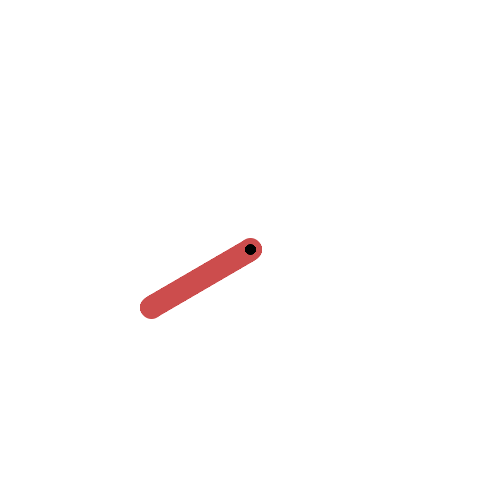

In [9]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env,
    action_converter=get_action_discreter(_render_env, BINS),
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用Pendulum-v1 环境，测试Policy-Based AC 算法

In [ ]:
from policy_based import PolicyValueNetTrainer, ActionStateValueNetFunc

GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'

env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/AC')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/AC/AC.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/AC')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 1000
HIDDEN_DIM = 512
LEARNING_RATE = 1e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   action_nums=BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)

value_func = ActionStateValueNetFunc(env.get_state_dim()[0],
                          action_nums=BINS,
                          hidden_dim=HIDDEN_DIM,
                          device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyValueNetTrainer(
                                  policy_func=policy_func,
                                  value_func=value_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH,
                                  action_converter=get_action_discreter(env, BINS))

#### 开始训练

In [ ]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
policy_func_trainer.train(train_epoch=TRAIN_EPOCH)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

policy_func.save(MODEL_PATH)

In [ ]:
start_train(
    StandarTrainProcess(
        trainer=policy_func_trainer,
        model=policy_func,
        train_epoch=TRAIN_EPOCH,
        log_path=LOG_PATH,
        model_path=MODEL_PATH
    )
)